In [1]:
import os
import glob
import copy
from datetime import datetime, time
import numpy as np
import pandas as pd
import math
os.environ["CDF_LIB"] = 'D:\我的课题文献\激光干涉\等离子体噪声\cdf3.8.0_64bit_VS2015\lib'
from spacepy import pycdf
from matplotlib import pyplot as plt
from matplotlib import gridspec
from astropy import units as u
from astropy import constants as c
from astropy.modeling import models, powerlaws, functional_models, custom_model, fitting
from scipy.signal import welch, medfilt, butter, filtfilt, savgol_filter
#from chainconsumer import ChainConsumer
import scipy.signal as signal
from astropy.timeseries import LombScargle
from datetime import datetime
from datetime import date
import matplotlib.lines as mlines

C:\Users\PC70\AppData\Roaming\Python\Python310\site-packages\spacepy\time.py:2367: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [2]:
data_dir = './data/cdf'
files = glob.glob('{:s}/*.cdf'.format(data_dir))
print('{} files found!'.format(len(files)))

1856 files found!


## read data

### electron number density data

1529 files selected from 1856
11253471


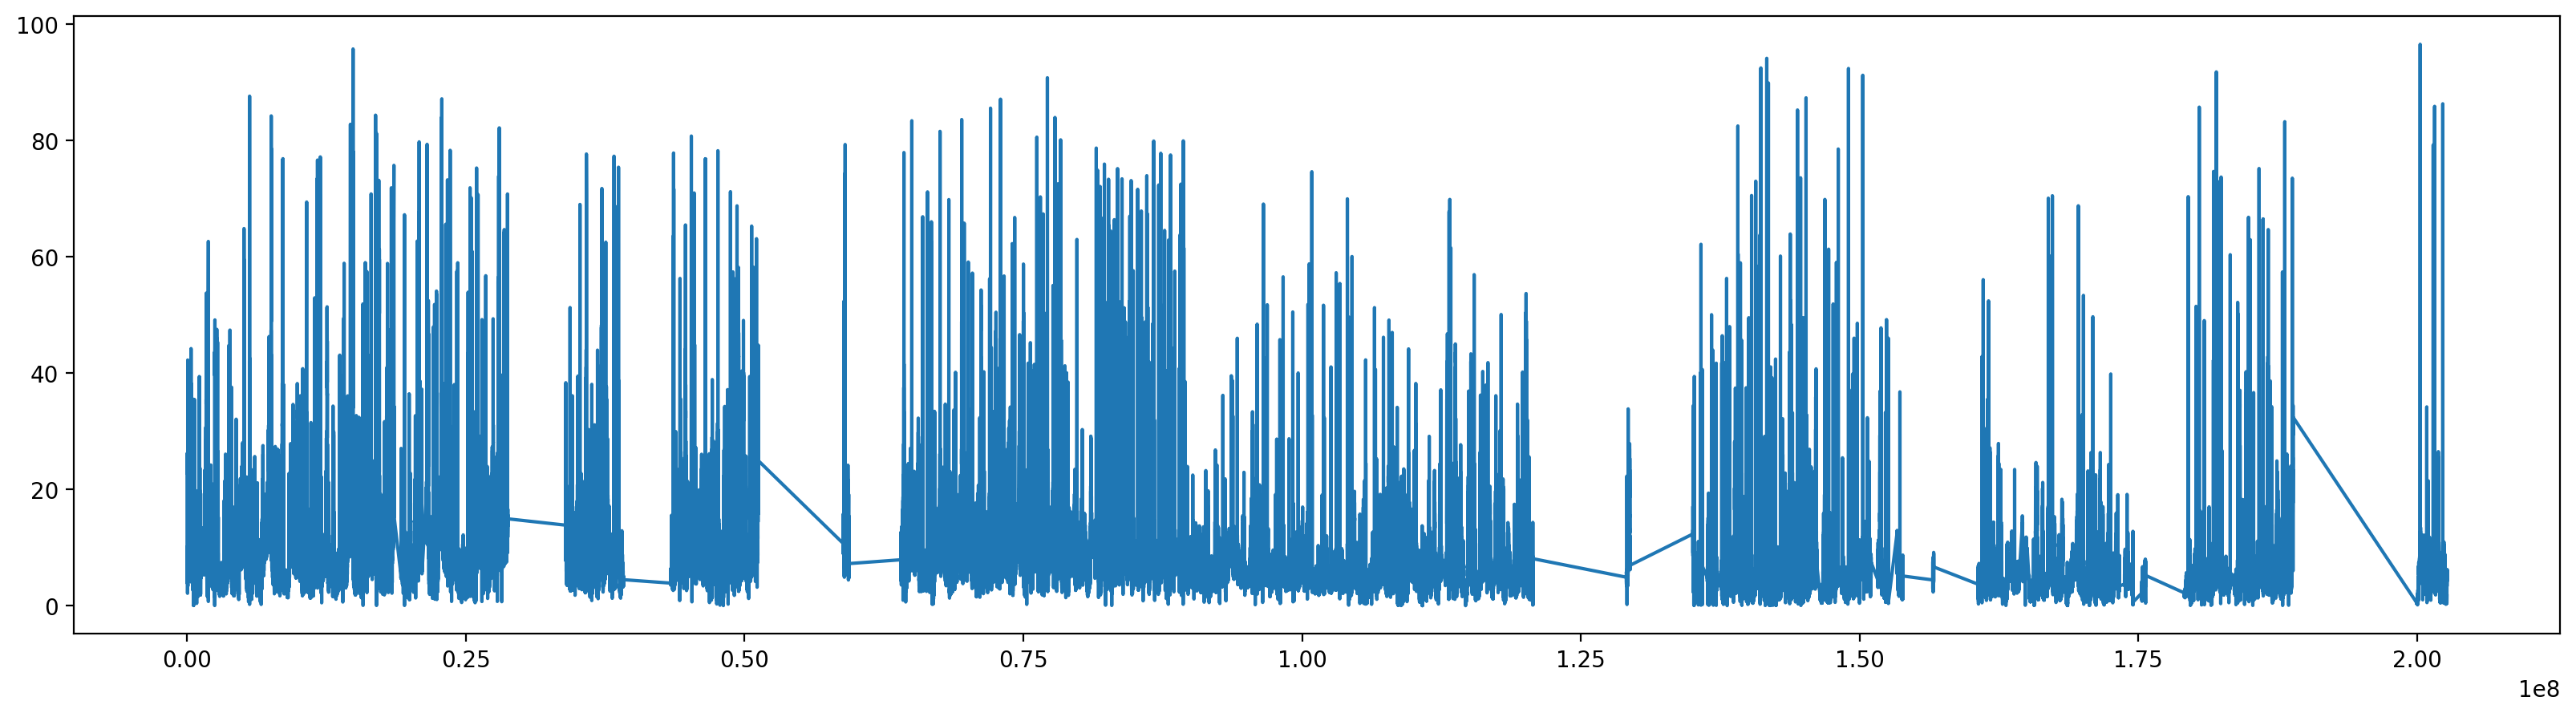

In [3]:

ed = []
seconds = []
datelist = []
epoch=[]
i=0


for file in files:
    #print(file)
    k=0

    cdf = pycdf.CDF(file)
   
    mean_sc_pos_x = np.mean(cdf['sc_position'][:,0])
    if mean_sc_pos_x <= 10:
        continue
    
    min_el_density = np.min(cdf['el_density'][:])
   
    if min_el_density < 0:
        continue
    
    max_el_density = np.max(cdf['el_density'][:])
    if max_el_density > 100:
        continue
    
    date_string_1 = str.split(file, '_')[3]
    date=datetime.strptime(date_string_1, '%Y%m%d')

    datelist.append(date)
    
    if len(datelist)>1:
        k=date-datelist[-2]
        i=i+k.days

    epoch_temp=np.array(cdf['Epoch'][:])
    
    midnight = datetime.combine(cdf['Epoch'][0].date(), time(hour=0))
    
    seconds_tmp = np.array([(t - midnight).seconds for t in cdf['Epoch'][:]])
    seconds_tmp1 = np.array([k+i*86400 for k in seconds_tmp])

    
   
    find = [True] + [x<y for x, y in zip(seconds_tmp1, seconds_tmp1[1:])]
    sec_temp=seconds_tmp1[find]
    
    _, index = np.unique(sec_temp, return_index=True)
    result = np.full(len(sec_temp), False)
    result[index] = True 
    
    ed=ed+cdf['el_density'][:][find][result].tolist()
    seconds_tmp2 = seconds_tmp1[find][result].tolist()
    seconds=seconds+seconds_tmp2
    epoch_temp=epoch_temp[find][result].tolist()
    epoch=epoch+epoch_temp
print("{} files selected from {}".format(len(datelist), len(files)))

fig = plt.figure(dpi=200)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.plot(seconds, ed)
#plt.show()
print(len(ed))


### 画图

In [4]:
cdfedarray=np.array(ed)
cdftimearray=np.array(epoch) 

cdf3=np.vstack((cdftimearray,cdfedarray))  
df = pd.DataFrame(cdf3.T,columns=['epoch','el_density'])
print(df.dtypes)
df.tail(5)

epoch         datetime64[ns]
el_density            object
dtype: object


,epoch,el_density
11253466,2001-05-31 23:58:58.401,5.325583
11253467,2001-05-31 23:59:10.818,5.416903
11253468,2001-05-31 23:59:23.235,5.448078
11253469,2001-05-31 23:59:35.651,5.100947
11253470,2001-05-31 23:59:57.381,5.288544


In [5]:
for i in range(1,len(df['epoch'])):
    time = df.loc[i,'epoch']
    oldtime = df.loc[i-1,'epoch']
    if (time-oldtime).days > 20:
        df.loc[i,'el_density'] = np.nan

<Figure size 1920x1440 with 0 Axes>

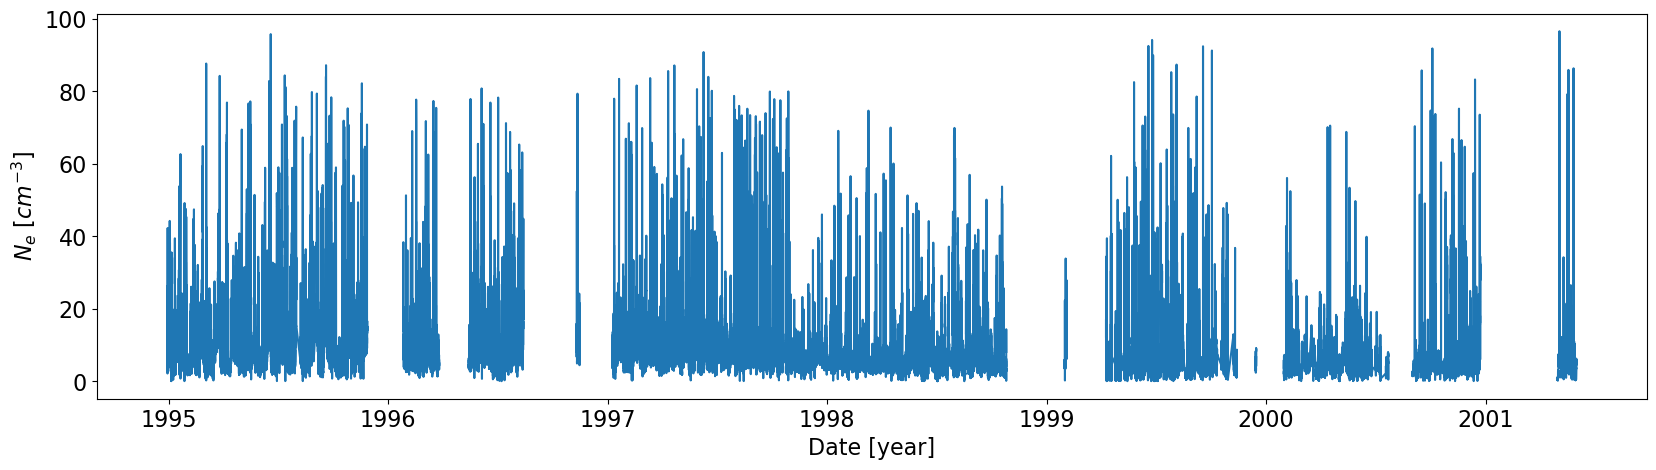

In [6]:
from datetime import datetime
from datetime import date
fig = plt.figure(dpi=300)
plt.figure(figsize=(20,5)) 
plt.plot(df['epoch'],df['el_density'])
plt.xlabel('Date [year]', fontsize=16)
plt.ylabel(r'$N_e$ [$cm^{-3}$]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('day_analysis.png',dpi=300)

plt.show()

In [7]:
from datetime import datetime
from datetime import date
df_newd=df.groupby([pd.Grouper(key='epoch',freq='D')])[['el_density']].mean().reset_index()

<Figure size 1920x1440 with 0 Axes>

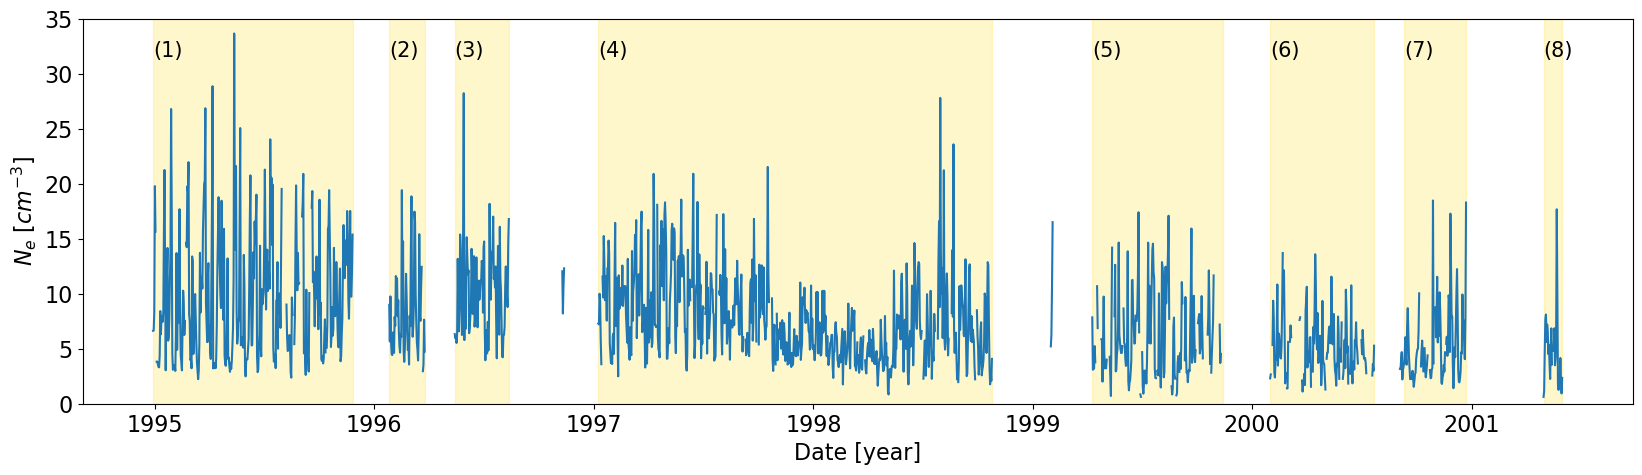

In [8]:
fig = plt.figure(dpi=300)
plt.figure(figsize=(20,5)) 
rr = [['1994-12-29','1995-11-26'],['1996-01-26','1996-03-25'],['1996-05-14','1996-08-12'],['1997-01-08','1998-10-25'],['1999-04-10','1999-11-13'],['2000-01-31','2000-07-22'],['2000-09-10','2000-12-22'],['2001-04-30','2001-05-31']]
rr_datetime = [[pd.to_datetime(date) for date in dates] for dates in rr]
ss = ['(1)','(2)','(3)','(4)','(5)','(6)','(7)','(8)']
ylim = [0,35]

plt.plot(df_newd['epoch'],df_newd['el_density'])
plt.xlabel('Date [year]', fontsize=16)
plt.ylabel(r'$N_e$ [$cm^{-3}$]',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(ylim[0],ylim[1])
for i in range(len(rr)):
    plt.fill_between(rr_datetime[i],ylim[0],ylim[1],color = 'gold',alpha = 0.2)
    plt.text(rr_datetime[i][0],(ylim[1]-ylim[0])*0.9+ylim[0],ss[i],size = 15)
#plt.savefig('day_analysis.png',dpi=300)
plt.show()
#plt.savefig('day_analysis.png',dpi=300)

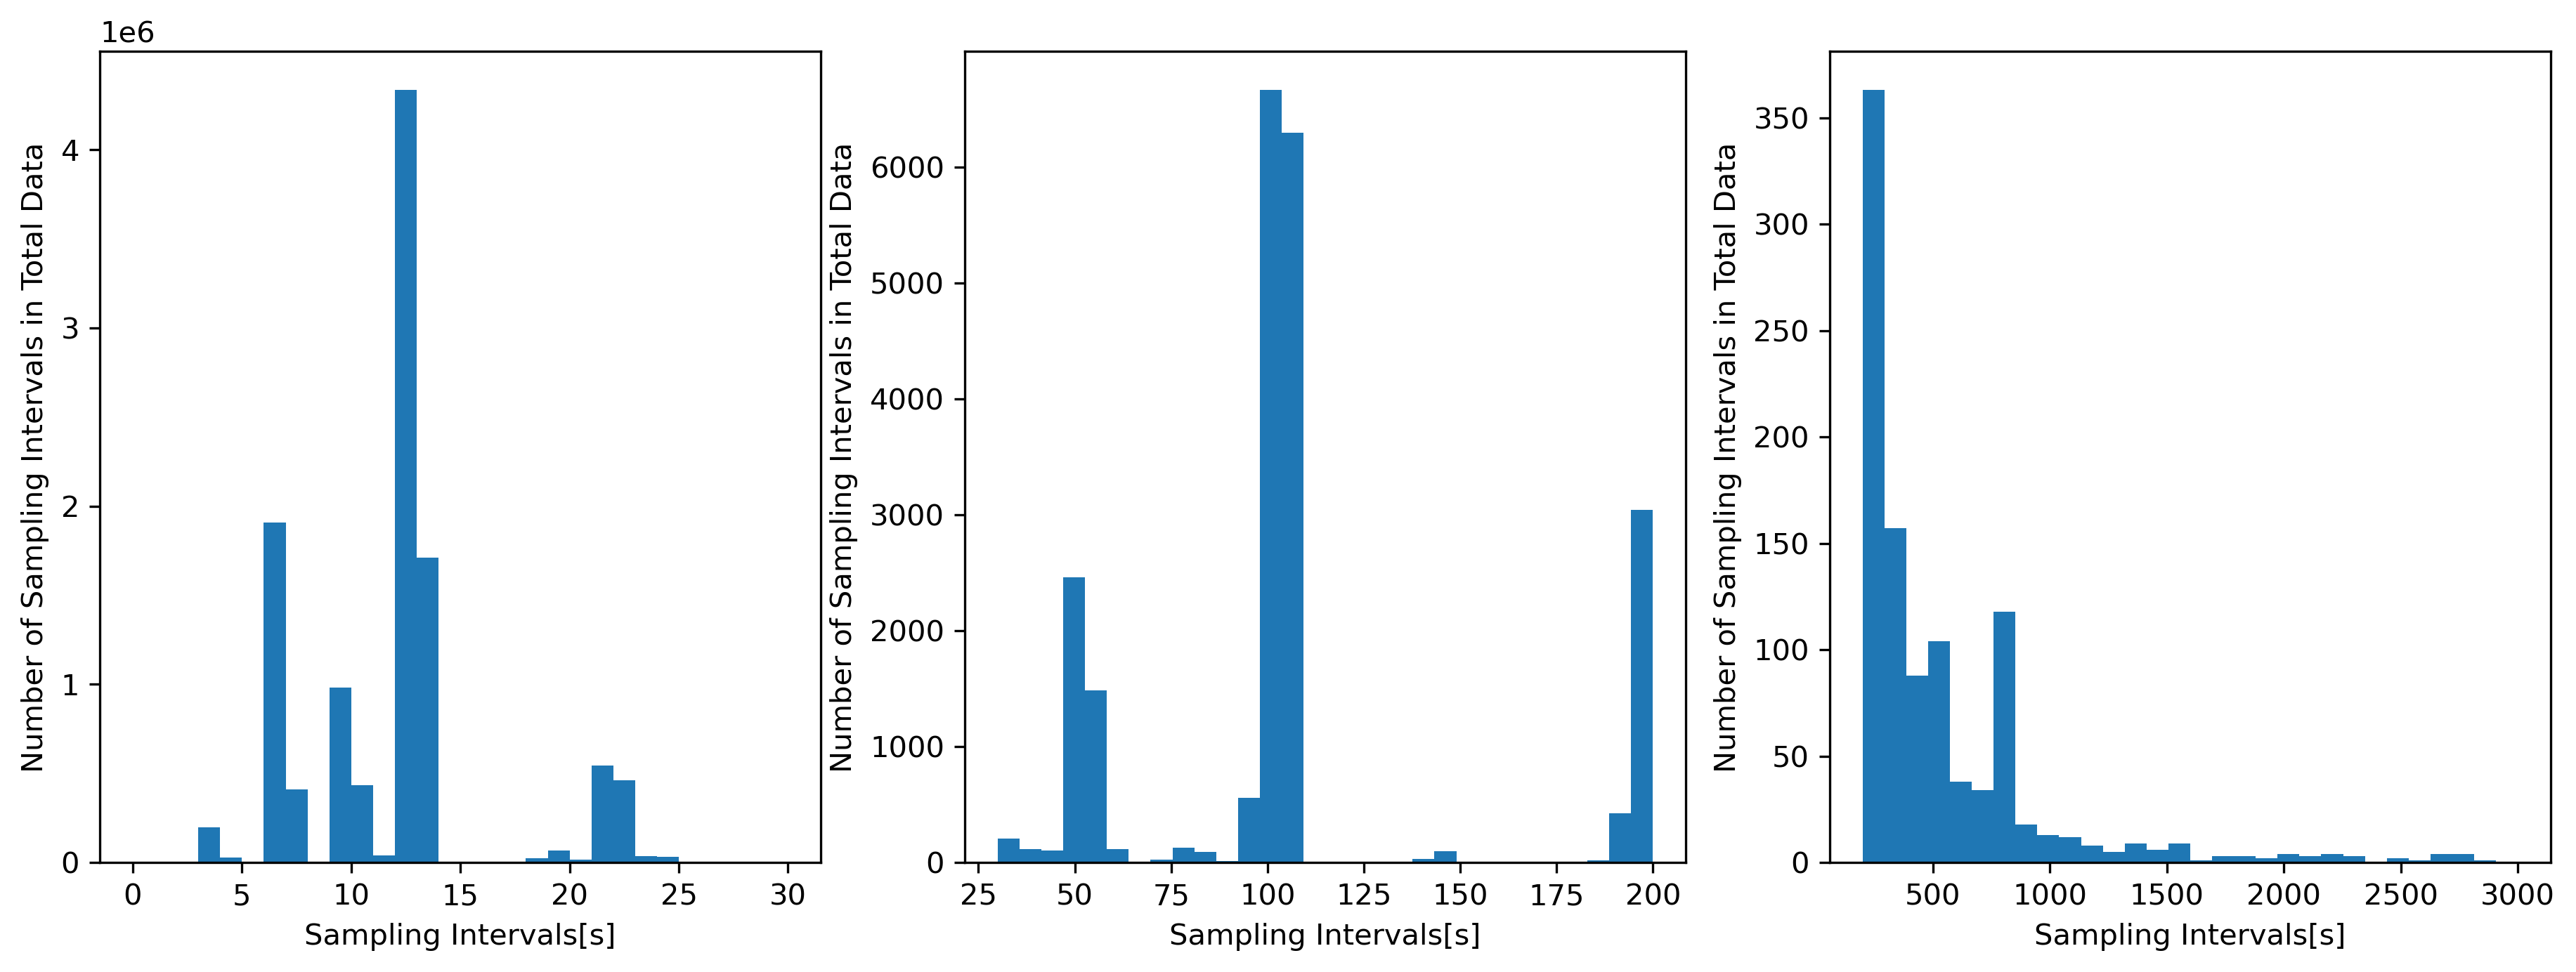

In [9]:
import matplotlib.pyplot as plt
import numpy as np


data_diff = np.diff(np.array(seconds))


fig, axs = plt.subplots(1, 3, figsize=(15, 5),dpi=300)

#
axs[0].hist(data_diff[(data_diff >= 0) & (data_diff <= 30)], bins=30, range=(0, 30))
axs[1].hist(data_diff[(data_diff > 30) & (data_diff <= 200)], bins=30, range=(30, 200))
axs[2].hist(data_diff[(data_diff > 200) & (data_diff <= 3000)], bins=30, range=(200, 3000))


for ax in axs:
    ax.set_xlabel('Sampling Intervals[s]')
    ax.set_ylabel('Number of Sampling Intervals in Total Data')


plt.show()

##  LombScargle PSD

### detrend

In [10]:

mean_value = np.mean(ed)
eds=ed-mean_value


### uncertainty

In [11]:

dy_all=0.1*mean_value

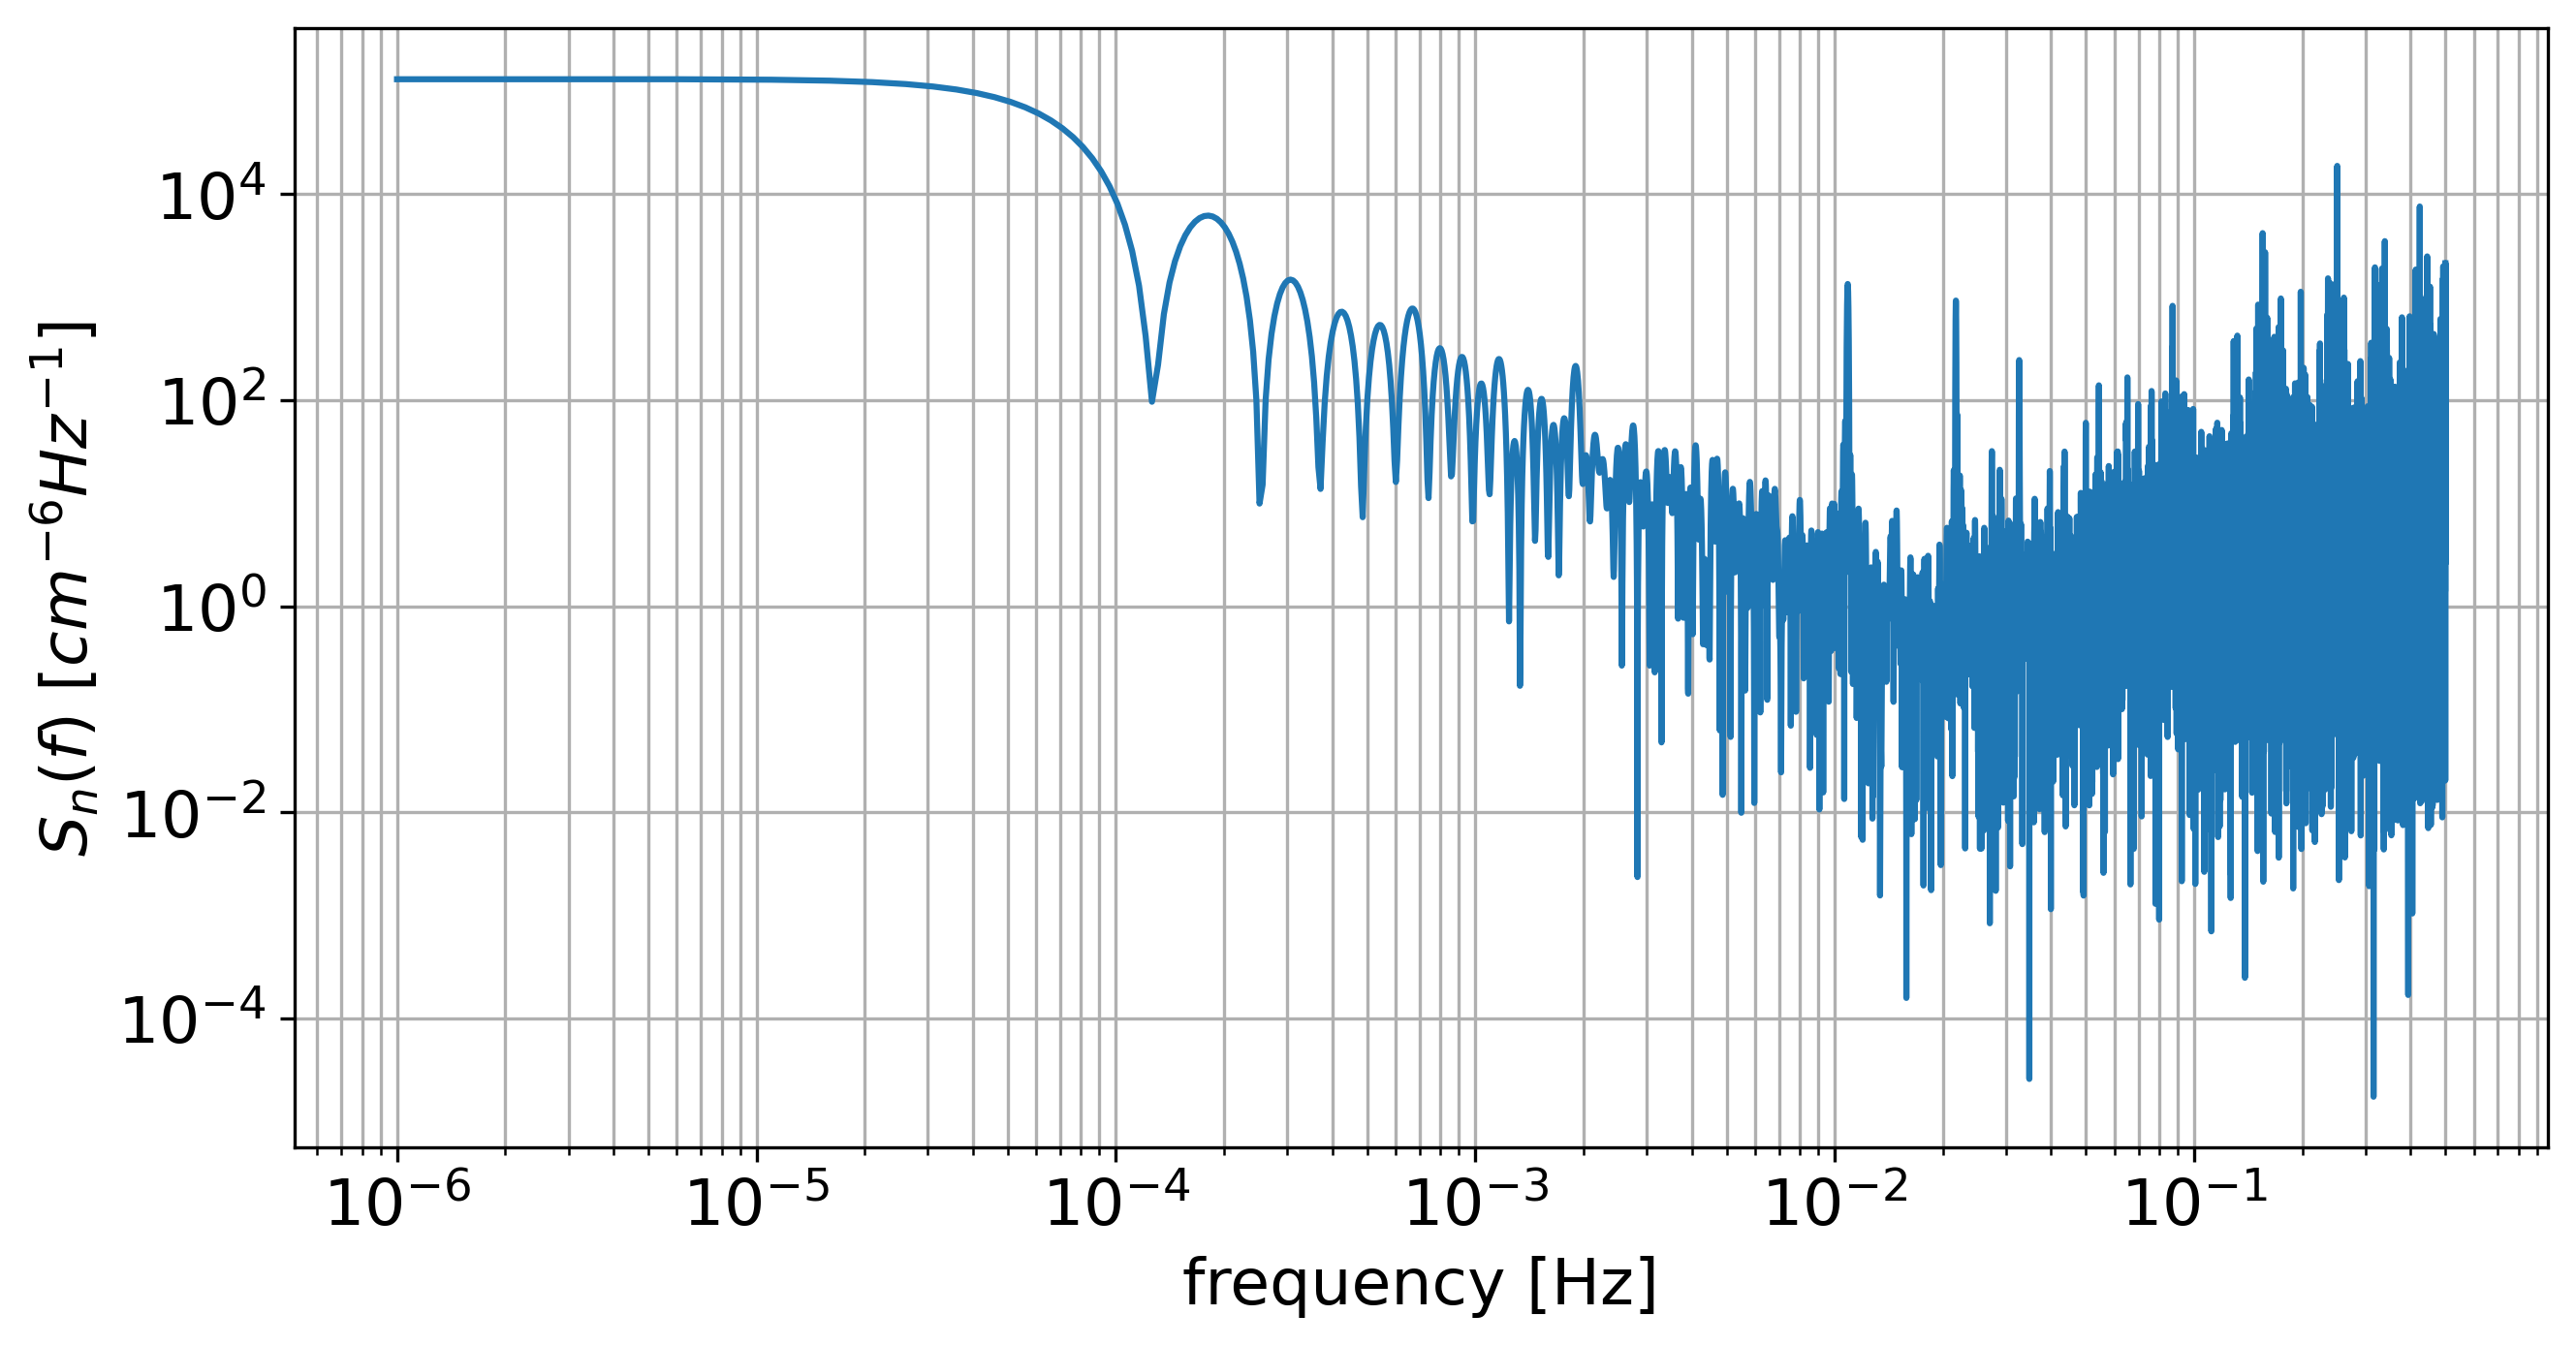

In [12]:

fig = plt.figure(dpi=300)
fig.set_figheight(5)
fig.set_figwidth(10)



w = np.linspace(0.000001, 0.5, 100000)

pgram = LombScargle(seconds, eds, dy_all,normalization='psd').power(w) 


plt.loglog(w, pgram)


plt.grid(which='both')
plt.xlabel('frequency [Hz]', fontsize=16)
plt.ylabel(r'$S_n(f)$ [$cm^{-6}Hz^{-1}$]',fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

## Fit PSD

-0.7761565242409524
-1.7291383298133307


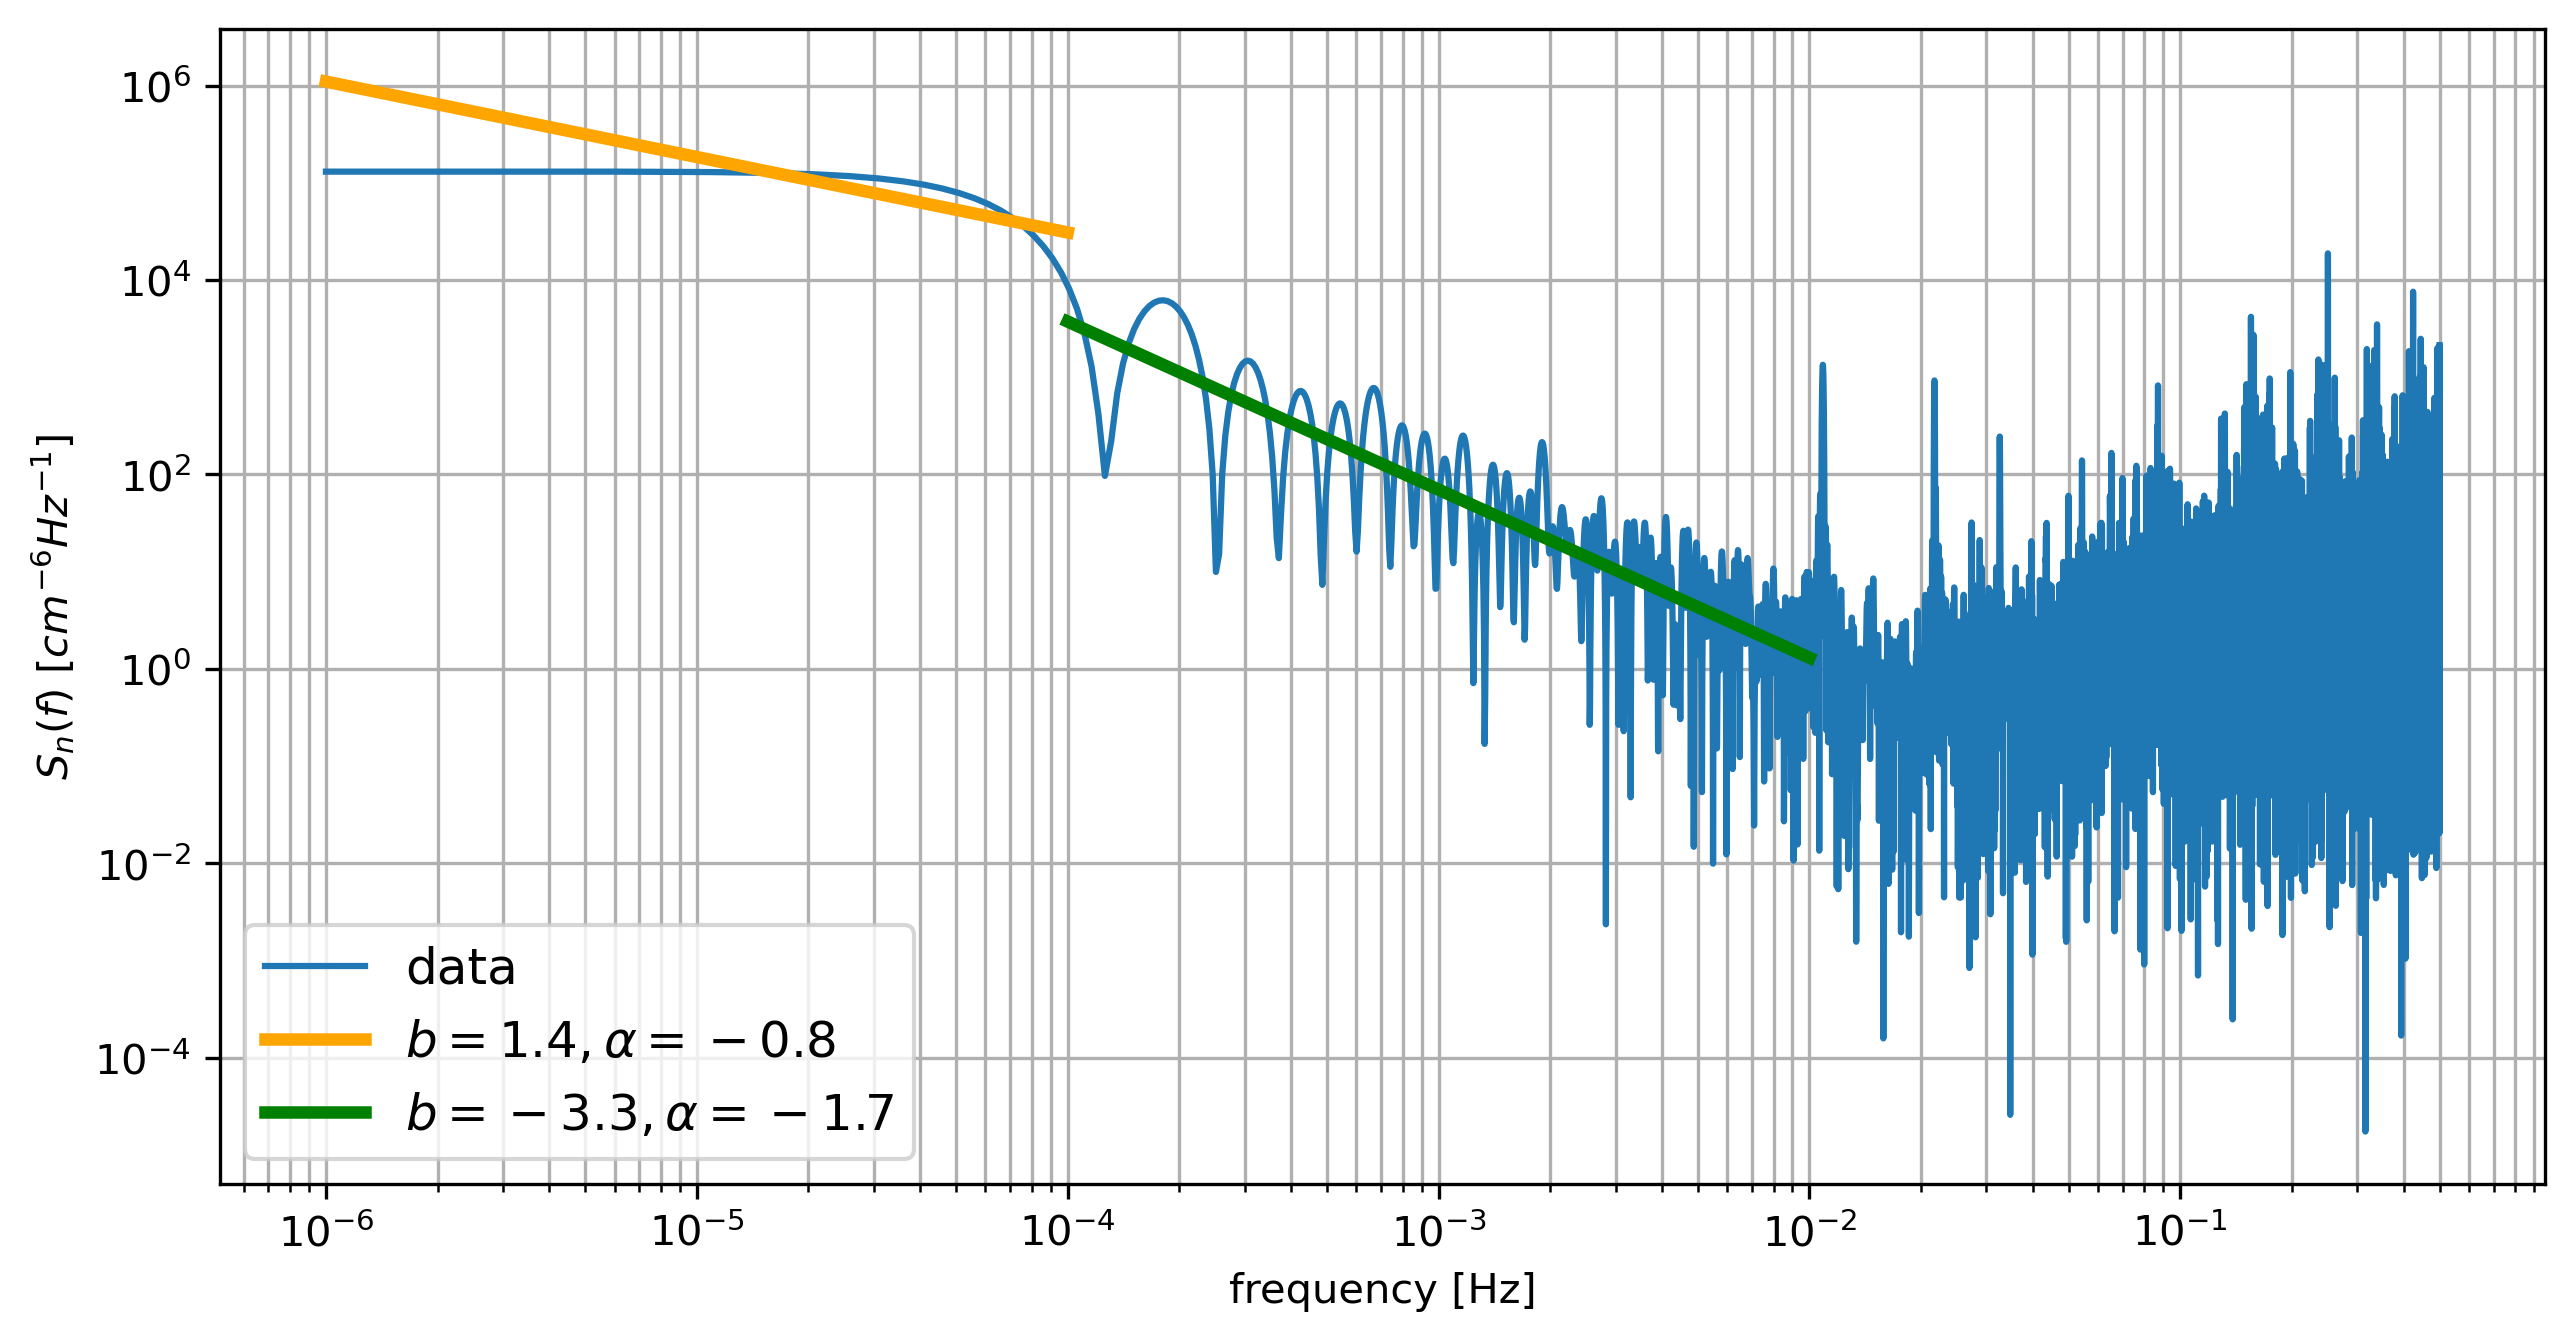

In [13]:
# 
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import norm
import pandas as pd


fig = plt.figure(dpi=300)
fig.set_figheight(5)
fig.set_figwidth(10)


def linear_model(x, a, b):
        return a * x + b

amplitudes=[]
alphas=[]
betabeta=[]
find=[(1e-6 < w) & (w < 1e-4),(1e-4 < w) & (w < 1e-2)]
fit_info = []
for i in range(2):
    
    xx=np.log10(w[find[i]])
    yy=np.log10(pgram[find[i]])
    params, covariance = curve_fit(linear_model, xx, yy)

    a_fit, b_fit = params

    stderr_a = np.sqrt(covariance[0, 0])
    
    if (i==0):
        amplitudes.append(10**(b_fit-5*a_fit))
    else:
        amplitudes.append(10**(b_fit-3*a_fit))
        
    alphas.append(a_fit)
    betabeta.append(b_fit)

plt.loglog(w, pgram,label='data')

ff=[np.logspace(-6,-4,100),np.logspace(-4,-2,100)]
color=["orange","green"]
x_00=[1e-5,1e-3]
for i in range(2):
    t1 = powerlaws.PowerLaw1D(amplitude = amplitudes[i], x_0 =x_00[i], alpha = -alphas[i])
    print(alphas[i])
    plt.plot(ff[i], t1(ff[i]), lw=3,label=r"$b=%2.1f, \alpha=%2.1f$" % (betabeta[i],alphas[i]),color=color[i])

plt.grid(which='both')
plt.legend(loc='lower left', fontsize=12)
#plt.title("lomb-scargle analyze [2001-1-31-2001-12-22]")
plt.xlabel('frequency [Hz]')
plt.ylabel(r'$S_n(f)$ [$cm^{-6}Hz^{-1}$]')

plt.show()

### Calculate confidence intervals

In [14]:


import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import t
from scipy.stats import norm


def linear_model(x, a, b):
    return a * x + b



find=[(1e-6 < w) & (w < 1e-4),(1e-4 < w) & (w < 1e-2)]
 
for i in range(2):
    x_data=np.log10(w[find[i]])
    y_data=np.log10(pgram[find[i]])
    
    
    params, covariance = curve_fit(linear_model, x_data, y_data)

   
    a_fit, b_fit = params
     
    stderr_a = np.sqrt(covariance[0, 0])
    stderr_b = np.sqrt(covariance[1, 1])
    print(stderr_a)
    alpha = 0.05  
    
    if(i==0):
        
        dof = len(x_data) - 2  
        t_critical = t.ppf(1 - alpha / 2, dof)  
        
        confidence_interval_a = (a_fit - t_critical * stderr_a , a_fit + t_critical * stderr_a)
        print("拟合频段------------:",i)
        print("a =", r"%2.1f" % (a_fit))
        print("b =", r"%2.1f" % (b_fit))
        
        print("置信区间:")
        print("置信区间(a) = [{:.2f}, {:.2f}]".format(confidence_interval_a[0], confidence_interval_a[1]))
        

       
    if(i==1):
    
        
        z_critical = norm.ppf(1 - alpha / 2)  
     
        confidence_interval_a = (a_fit - z_critical * stderr_a, a_fit + z_critical * stderr_a)
         
        print("拟合频段-------------:",i)
        print("a =", r"%2.1f" % (a_fit))
        print("b =", r"%2.1f" % (b_fit))
       
        print("置信区间:")
        print("置信区间(a) = [{:.2f}, {:.2f}]".format(confidence_interval_a[0], confidence_interval_a[1]))
        


0.14030619232029706
拟合频段------------: 0
a = -0.8
b = 1.4
置信区间:
置信区间(a) = [-1.07, -0.48]
0.0318983675369387
拟合频段-------------: 1
a = -1.7
b = -3.3
置信区间:
置信区间(a) = [-1.79, -1.67]


### Single arm displacement noise

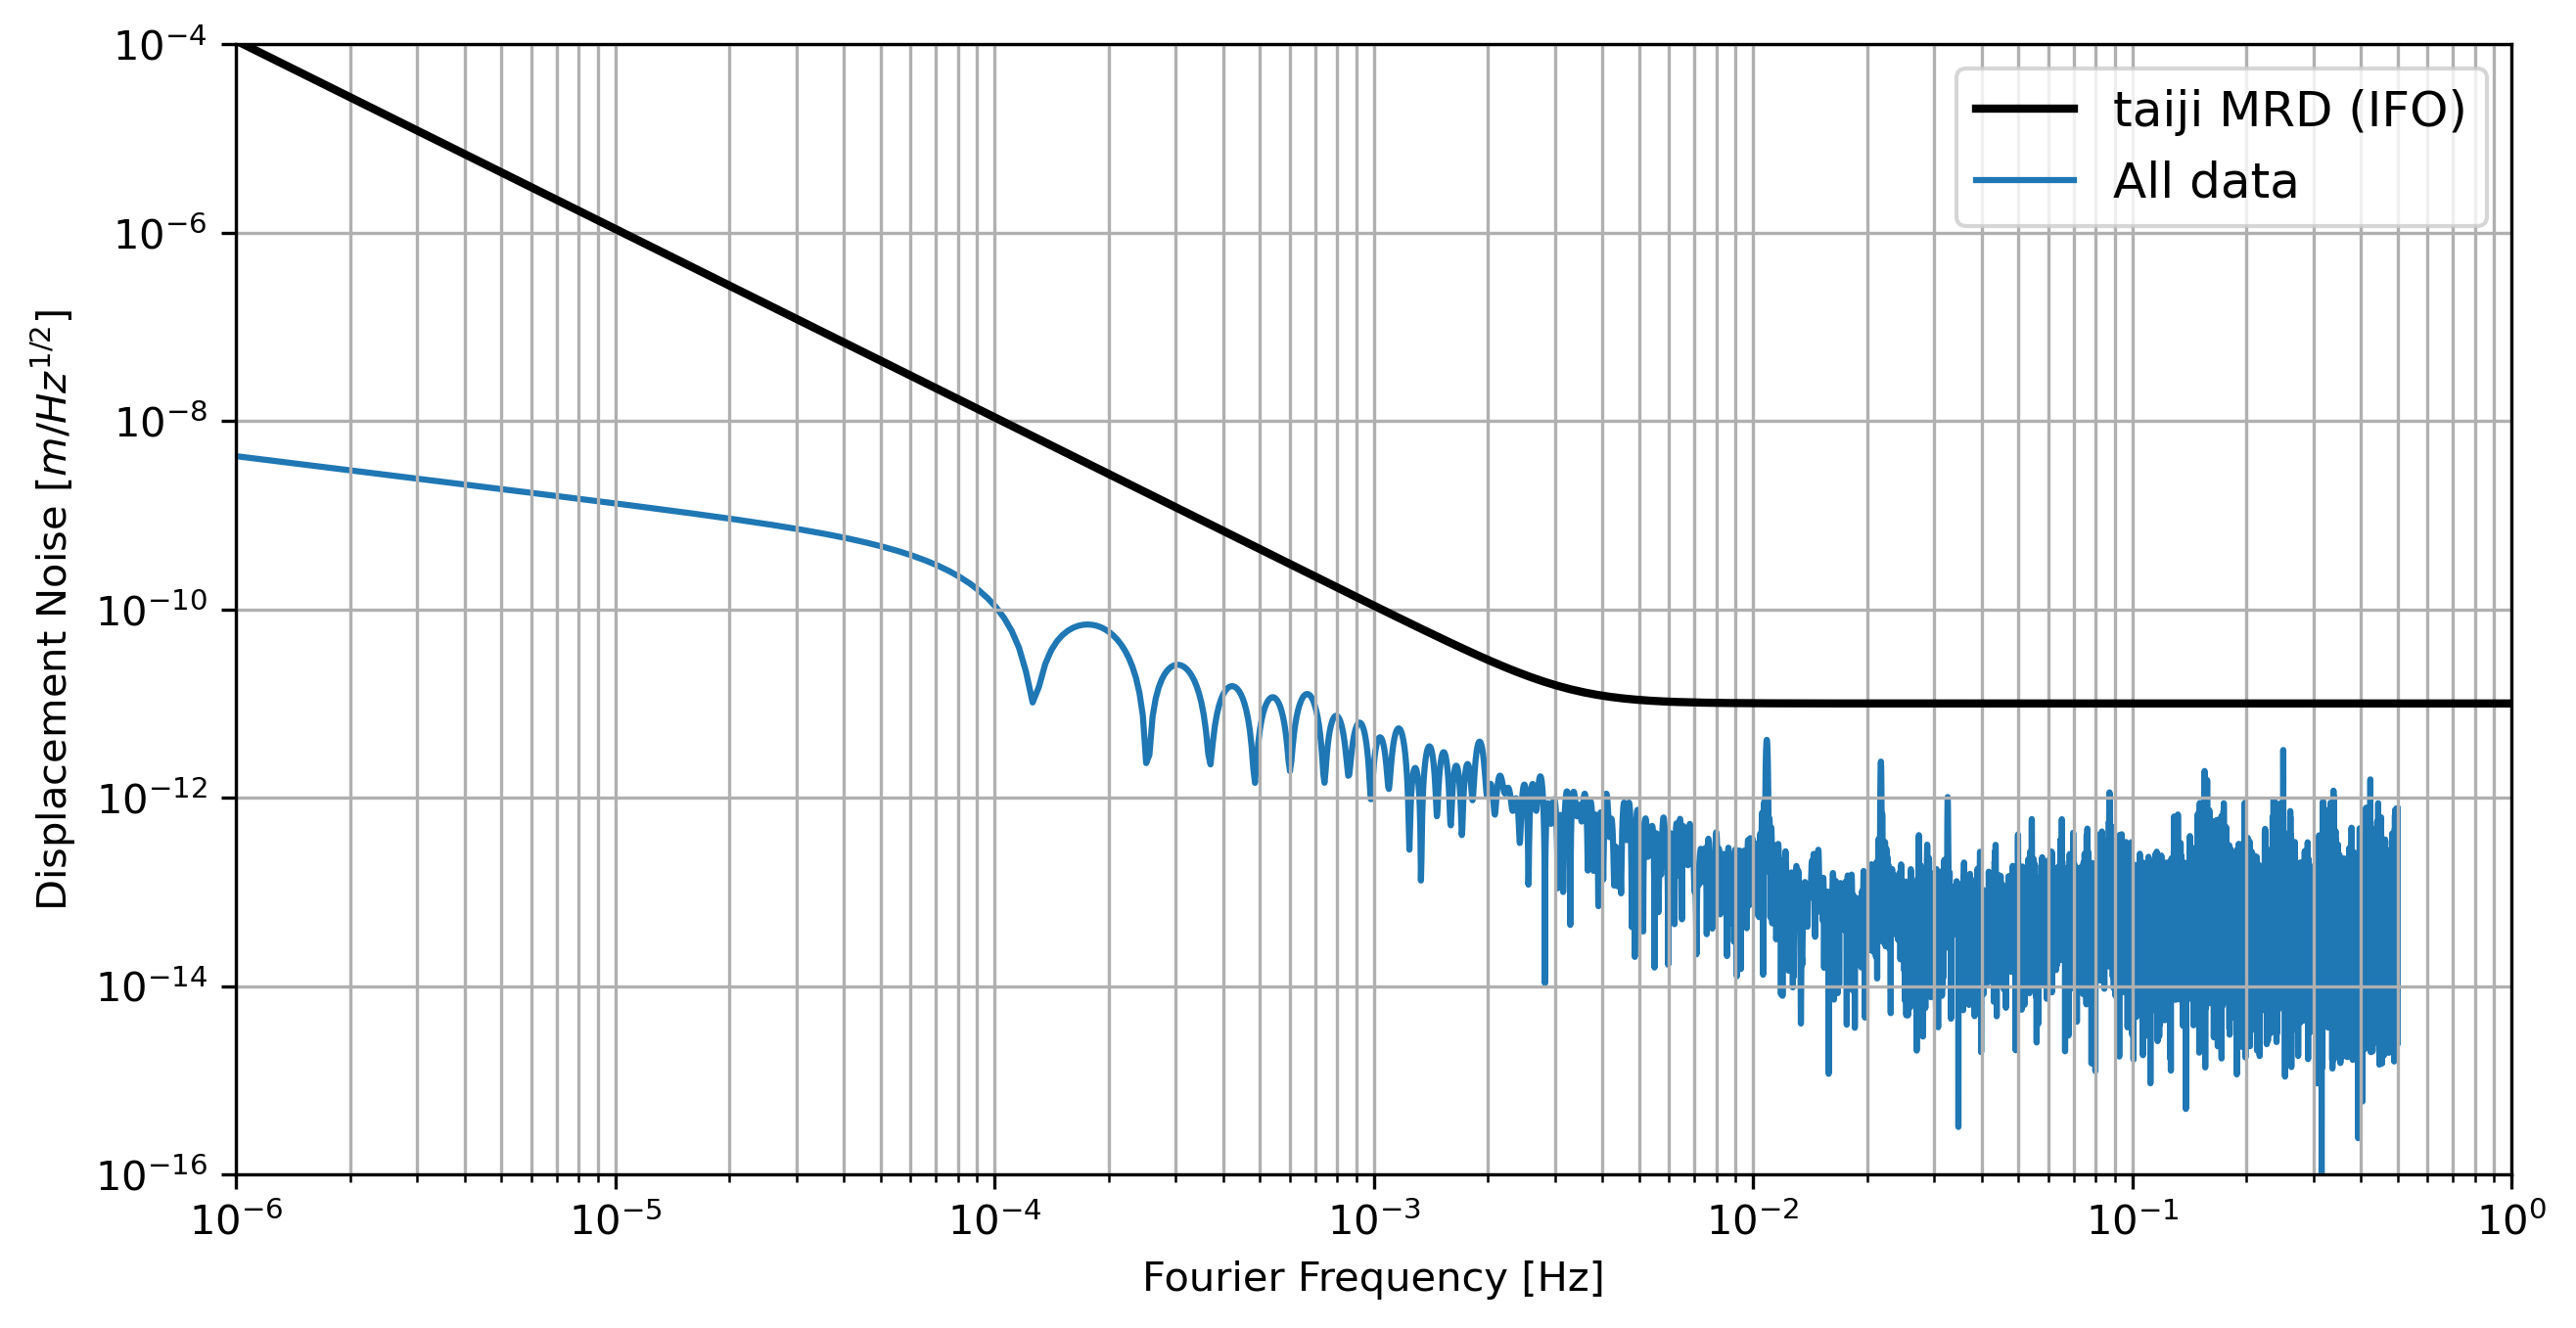

In [20]:

L = 3.0e9*u.m  
Beta=1.0
Beta1 = 1.0  
Beta2 = 1.0
Beta3 = 1.0
lam = 1064e-9*u.m # laser wavelength 
chi = ((lam.cgs**2)*(c.e.esu)**2)/(2*np.pi*c.m_e.cgs*(c.c.cgs**2))
chi.decompose().cgs




V = 400e3 * u.m / u.s # Velocity of solar wind
def TF1arm(f,avg_type='1arm'):
    cm2m = 0.01
    prefix = (L*chi)**2
    if avg_type =='1arm':
        tf = prefix*((25/9)*(Beta**(5/3))*(V/(2*np.pi*L*f)))
    return (cm2m**2)*(tf.decompose().cgs.to_value())


def MRD_one_link_IFO(f):
    return 1e-11*np.sqrt((1+(3.3e-3/f)**4))

f = np.array(w)

sneAll = np.array(pgram)

tfmod = '1arm'
fig, ax = plt.subplots(nrows=1, figsize=(10, 5), dpi=300)

ff1 = np.logspace(-6,1,200)


ax.plot(ff1, MRD_one_link_IFO(ff1), lw=2, color='black', linestyle='-',label='taiji MRD (IFO)')
ax.plot(f, np.sqrt(sneAll*TF1arm(f,avg_type=tfmod)), zorder=0, label='All data')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Displacement Noise [$m/Hz^{1/2}$]')
ax.set_xlim([1e-6, 1])
ax.set_ylim([1e-16, 1e-4])
ax.grid(which='both')
ax.legend(loc='upper right', fontsize=12)
fig.savefig('single_all_data_taiji.jpg')

### TDI result

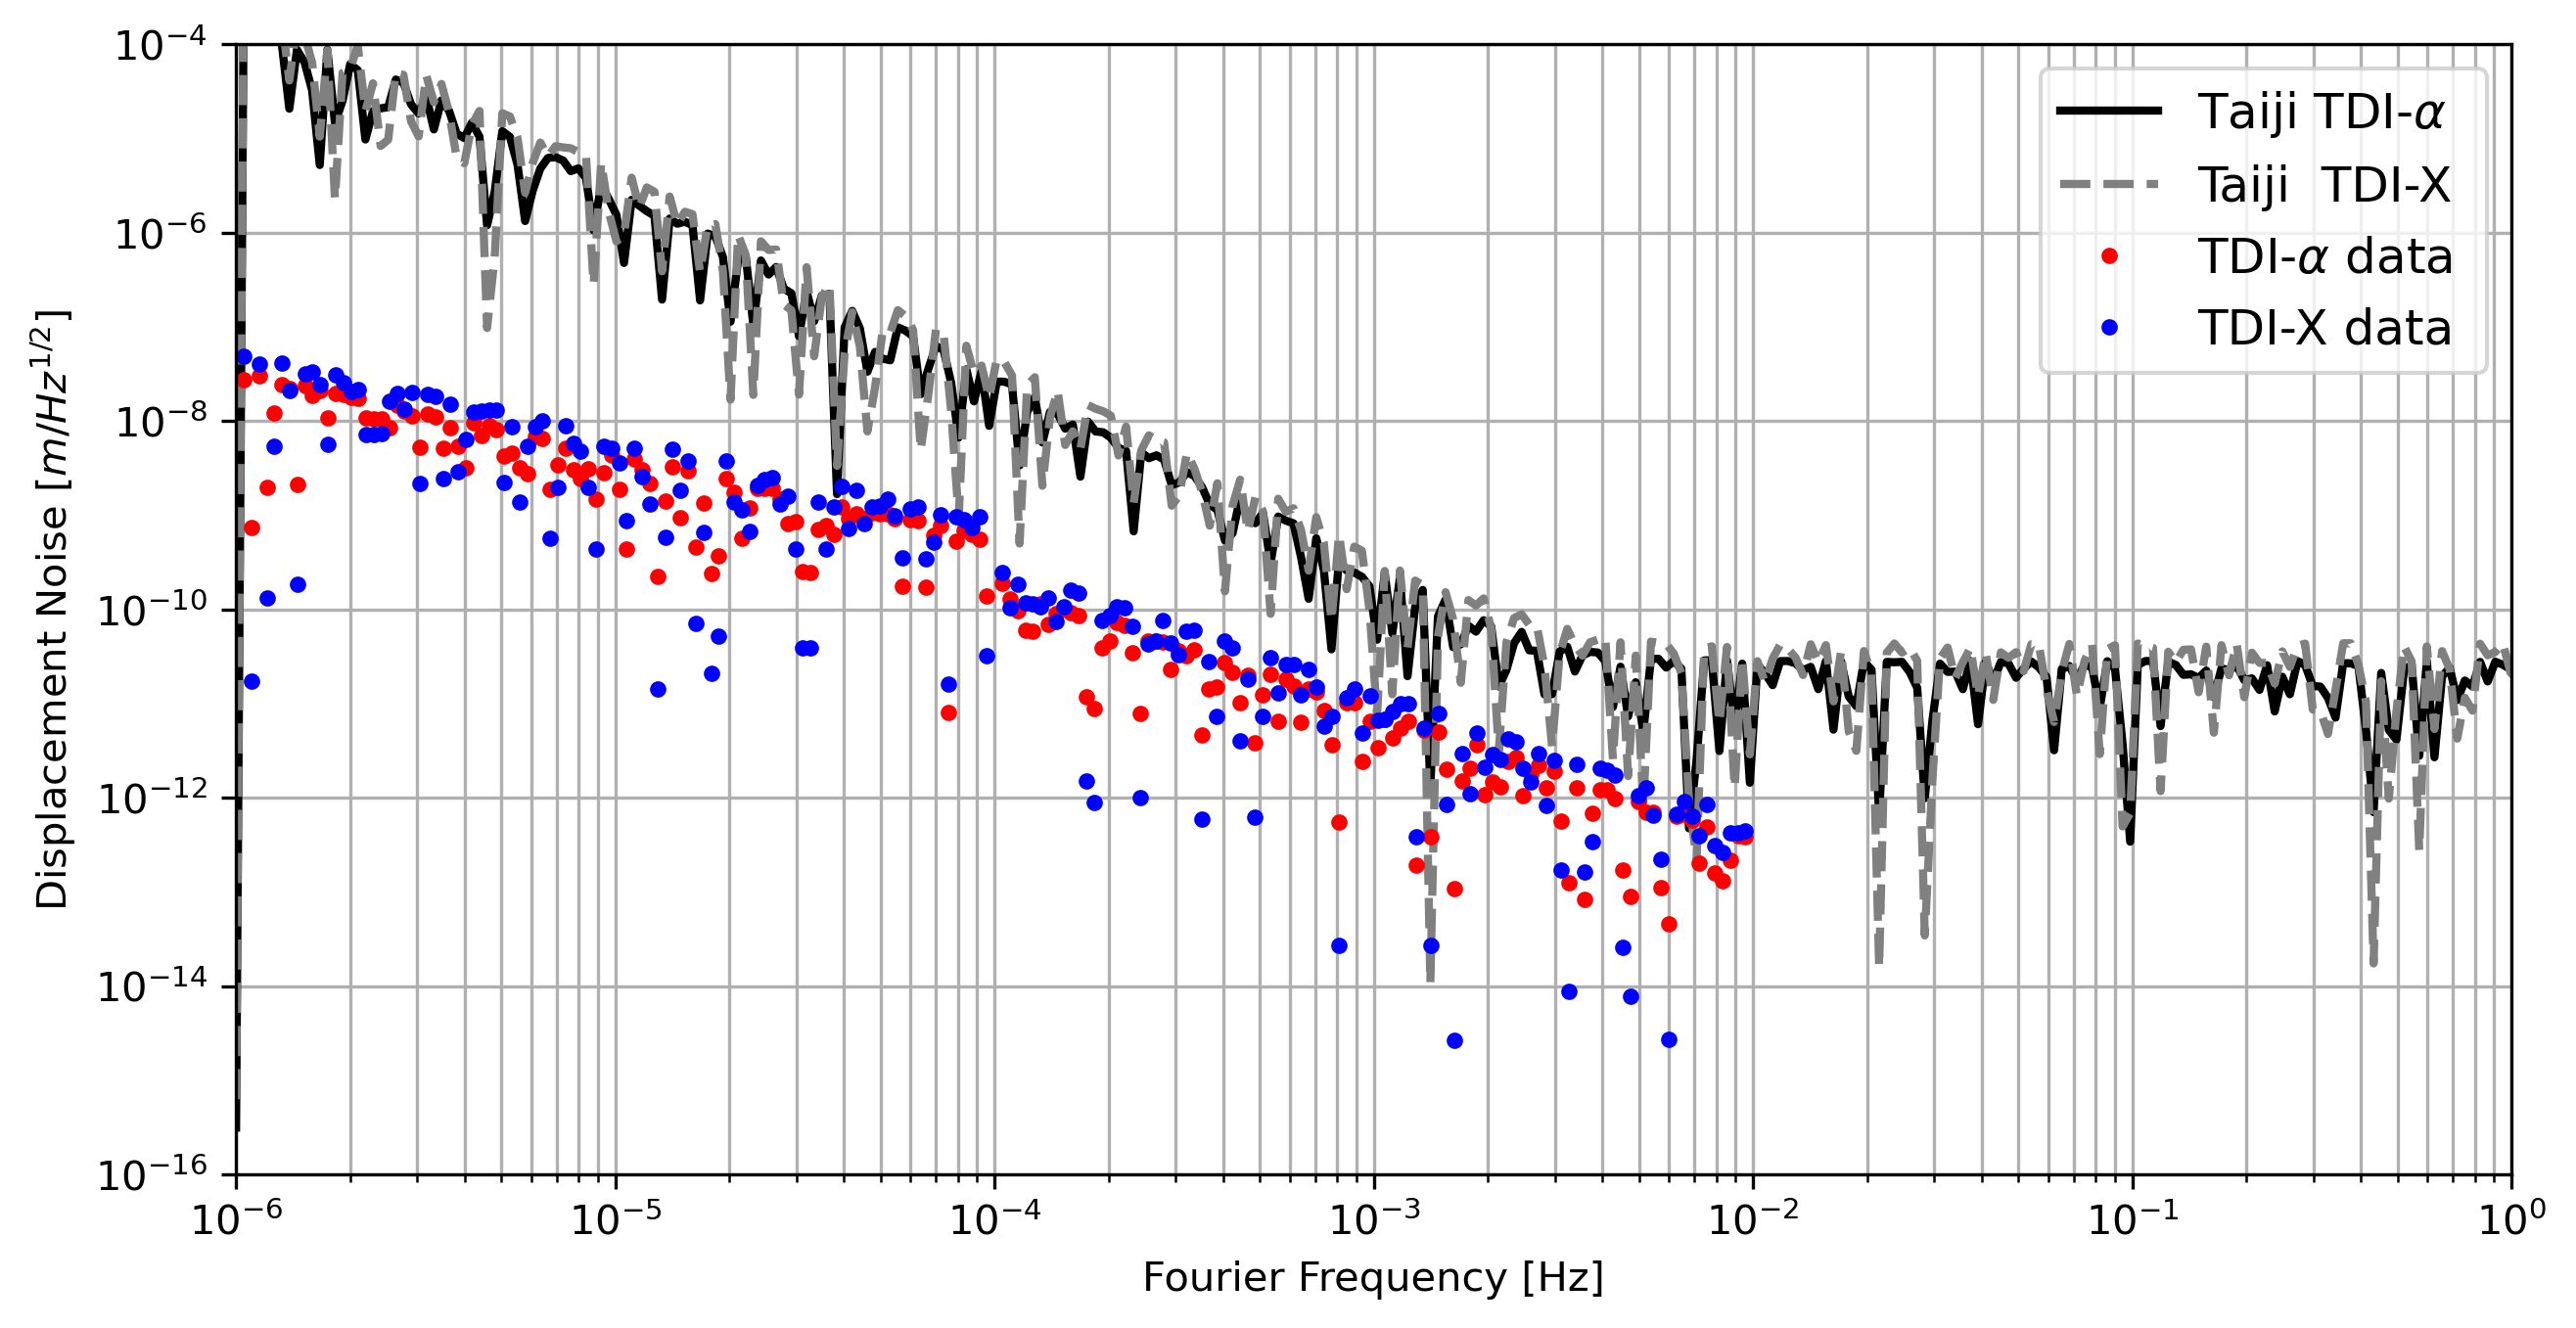

In [21]:

L = 3.0e9*u.m 
Beta = 1.0
Beta1 = 1.0  
Beta2 = 1.0
Beta3 = 1.0
lam = 1064e-9*u.m # laser wavelength 
chi = ((lam.cgs**2)*(c.e.esu)**2)/(2*np.pi*c.m_e.cgs*(c.c.cgs**2))
chi.decompose().cgs



V = 400e3 * u.m / u.s

def TF1arm(f,avg_type='1arm'):
    s1=4*np.sin(2*np.pi*f*L.value)*np.sin(2*np.pi*f*L.value)
    s2=4*np.cos(np.pi*f*L.value)*np.cos(np.pi*f*L.value)
    cm2m = 0.01
    prefix = (L*chi)**2
    if avg_type =='1arm':
        tf = prefix*((25/9)*(Beta**(5/3))*(V/(2*np.pi*L*f)))
    elif avg_type =='1armtdi1a':
        tf = prefix*((25/9)*(Beta2**(5/3))*(V/(2*np.pi*L*f)))*s1+prefix*((25/9)*(Beta3**(5/3))*(V/(2*np.pi*L*f)))*s1
    elif avg_type =='1armtdi1x':
        tf = prefix*((25/9)*(Beta2**(5/3))*(V/(2*np.pi*L*f)))*s1*s2+prefix*((25/9)*(Beta3**(5/3))*(V/(2*np.pi*L*f)))*s1*s2
    elif avg_type == 'none':
        tf = prefix
    
    return (cm2m**2)*(tf.decompose().cgs.to_value())


def MRD_one_link_IFO(f):
    return 1e-11*np.sqrt((1+(3.3e-3/f)**4))

def MRD_TDI_alpha(f):
    s1=4*np.sin(2*np.pi*f*L.value)*np.sin(2*np.pi*f*L.value)
    return np.sqrt(2*s1*(1e-11*np.sqrt((1+(3.3e-3/f)**4)))**2)

def MRD_TDI_X(f):
    s1=4*np.sin(2*np.pi*f*L.value)*np.sin(2*np.pi*f*L.value)
    s2=4*np.cos(np.pi*f*L.value)*np.cos(np.pi*f*L.value)
    return np.sqrt(2*s1*s2*(1e-11*np.sqrt((1+(3.3e-3/f)**4)))**2)



f = np.array(w)

sneAll = np.array(pgram)

tfmod = '1arm'
fig, ax = plt.subplots(nrows=1, figsize=(10, 5), dpi=300)
ff1 = np.logspace(-6,1,350)

ax.plot(ff1, MRD_TDI_alpha(ff1), lw=2, color='black',linestyle='-',label=r'Taiji TDI-$\alpha$ ')
ax.plot(ff1, MRD_TDI_X(ff1), lw=2, color='grey', linestyle='--',label='Taiji  TDI-X ')

cm2m = 0.01


ff=[np.logspace(-6,-4,100),np.logspace(-4,-2,100)]


for i in range(2):
    
    ff[i] = ff[i]
    t1 = powerlaws.PowerLaw1D(amplitude = amplitudes[i], x_0 =x_00[i], alpha = -alphas[i])
    
    
    if (i==1):
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1a')),'.',color='red', label=r'TDI-$\alpha$ data',lw=1)
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1x')),'.',color='blue',label=r'TDI-X data', lw=1)
        
    else:
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1a')),'.',color='red',lw=1)
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1x')),'.',color='blue',lw=1)
        


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Displacement Noise [$m/Hz^{1/2}$]')
ax.set_xlim([1e-6, 1])
ax.set_ylim([1e-16,1e-4])


ax.grid(which='both')
ax.legend(loc='upper right', fontsize=12)
fig.savefig('TDI_all_data_taiji.jpg')

### background noise

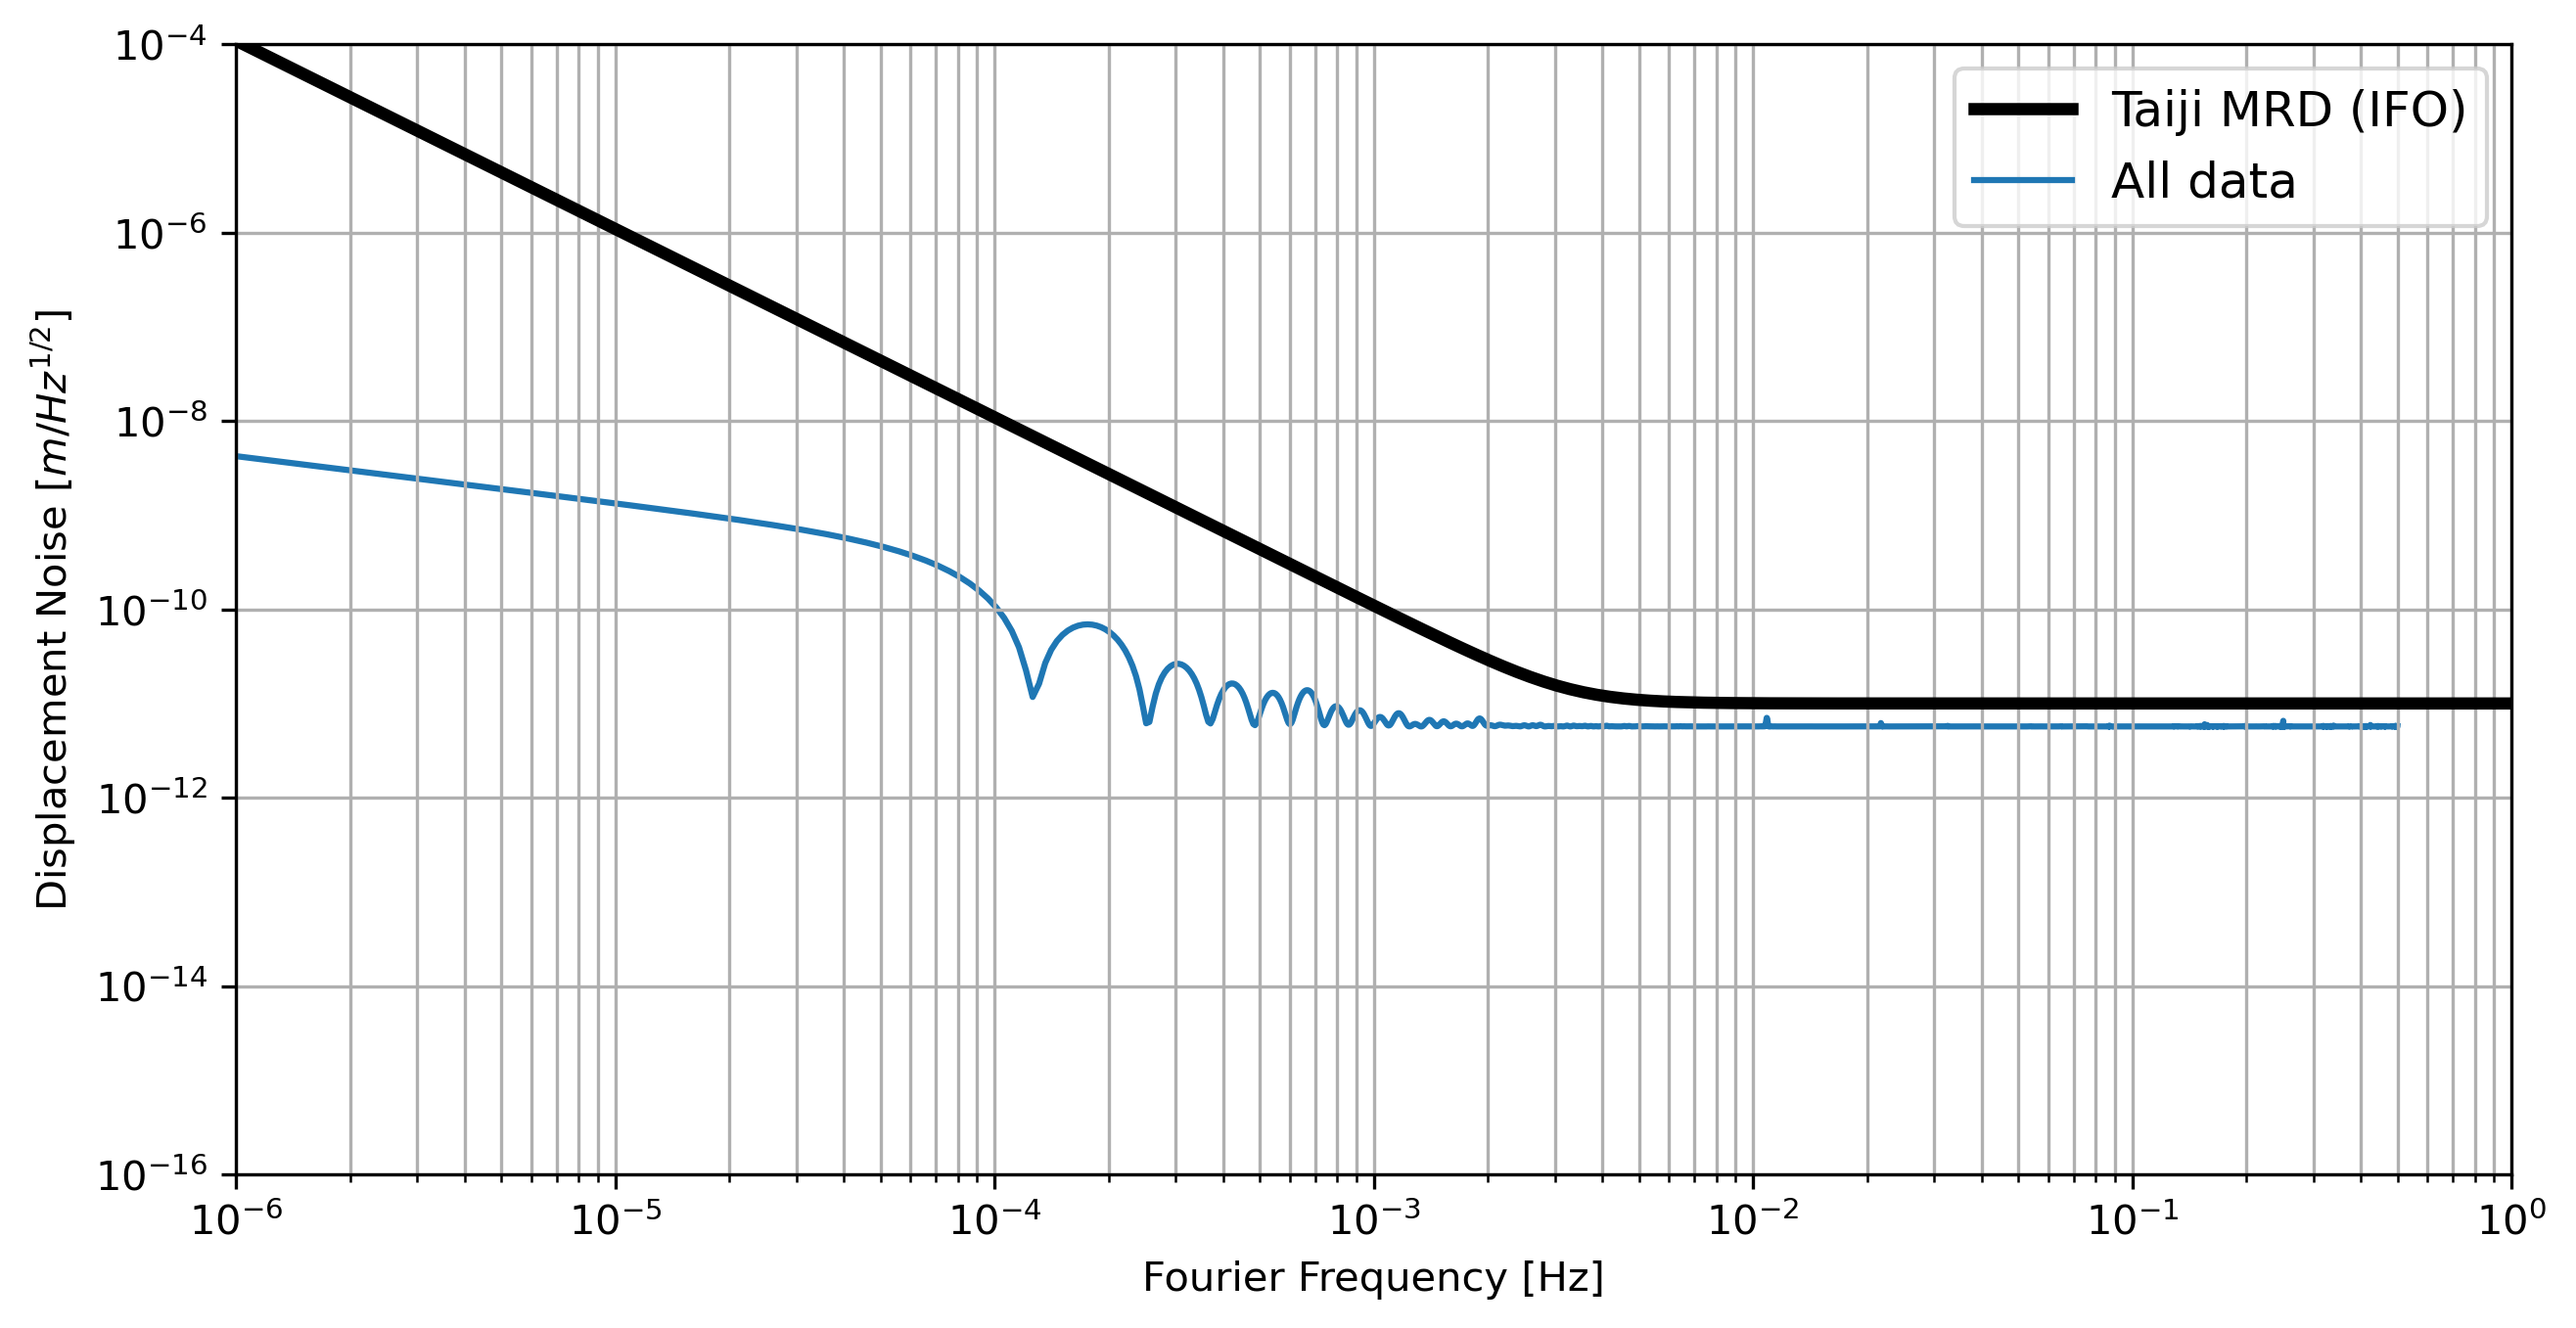

In [22]:
L = 3.0e9*u.m  
Beta=1.0
Beta1 = 1.0  
Beta2 = 1.0
Beta3 = 1.0
lam = 1064e-9*u.m # laser wavelength 
chi = ((lam.cgs**2)*(c.e.esu)**2)/(2*np.pi*c.m_e.cgs*(c.c.cgs**2))
chi.decompose().cgs




V = 400e3 * u.m / u.s # Velocity of solar wind
def TF1arm(f,avg_type='1arm'):
    cm2m = 0.01
    prefix = (L*chi)**2
    if avg_type =='1arm':
        tf = prefix*((25/9)*(Beta**(5/3))*(V/(2*np.pi*L*f)))
    return (cm2m**2)*(tf.decompose().cgs.to_value())



def MRD_one_link_IFO(f):
    return 1e-11*np.sqrt((1+(3.3e-3/f)**4))



f = np.array(w)

sneAll = np.array(pgram)

tfmod = '1arm'
fig, ax = plt.subplots(nrows=1, figsize=(10, 5), dpi=300)

ff1 = np.logspace(-6,1,200)

ax.plot(ff1, MRD_one_link_IFO(ff1), lw=3, color='black', linestyle='-',label='Taiji MRD (IFO)')
ax.plot(f, np.sqrt(sneAll*TF1arm(f,avg_type=tfmod)+32.49e-24), zorder=0, label='All data')


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Displacement Noise [$m/Hz^{1/2}$]')
ax.set_xlim([1e-6, 1])
ax.set_ylim([1e-16, 1e-4])
ax.grid(which='both')
ax.legend(loc='upper right', fontsize=12)
fig.savefig('background_noise_taiji.jpg')

### TDI result of background noise

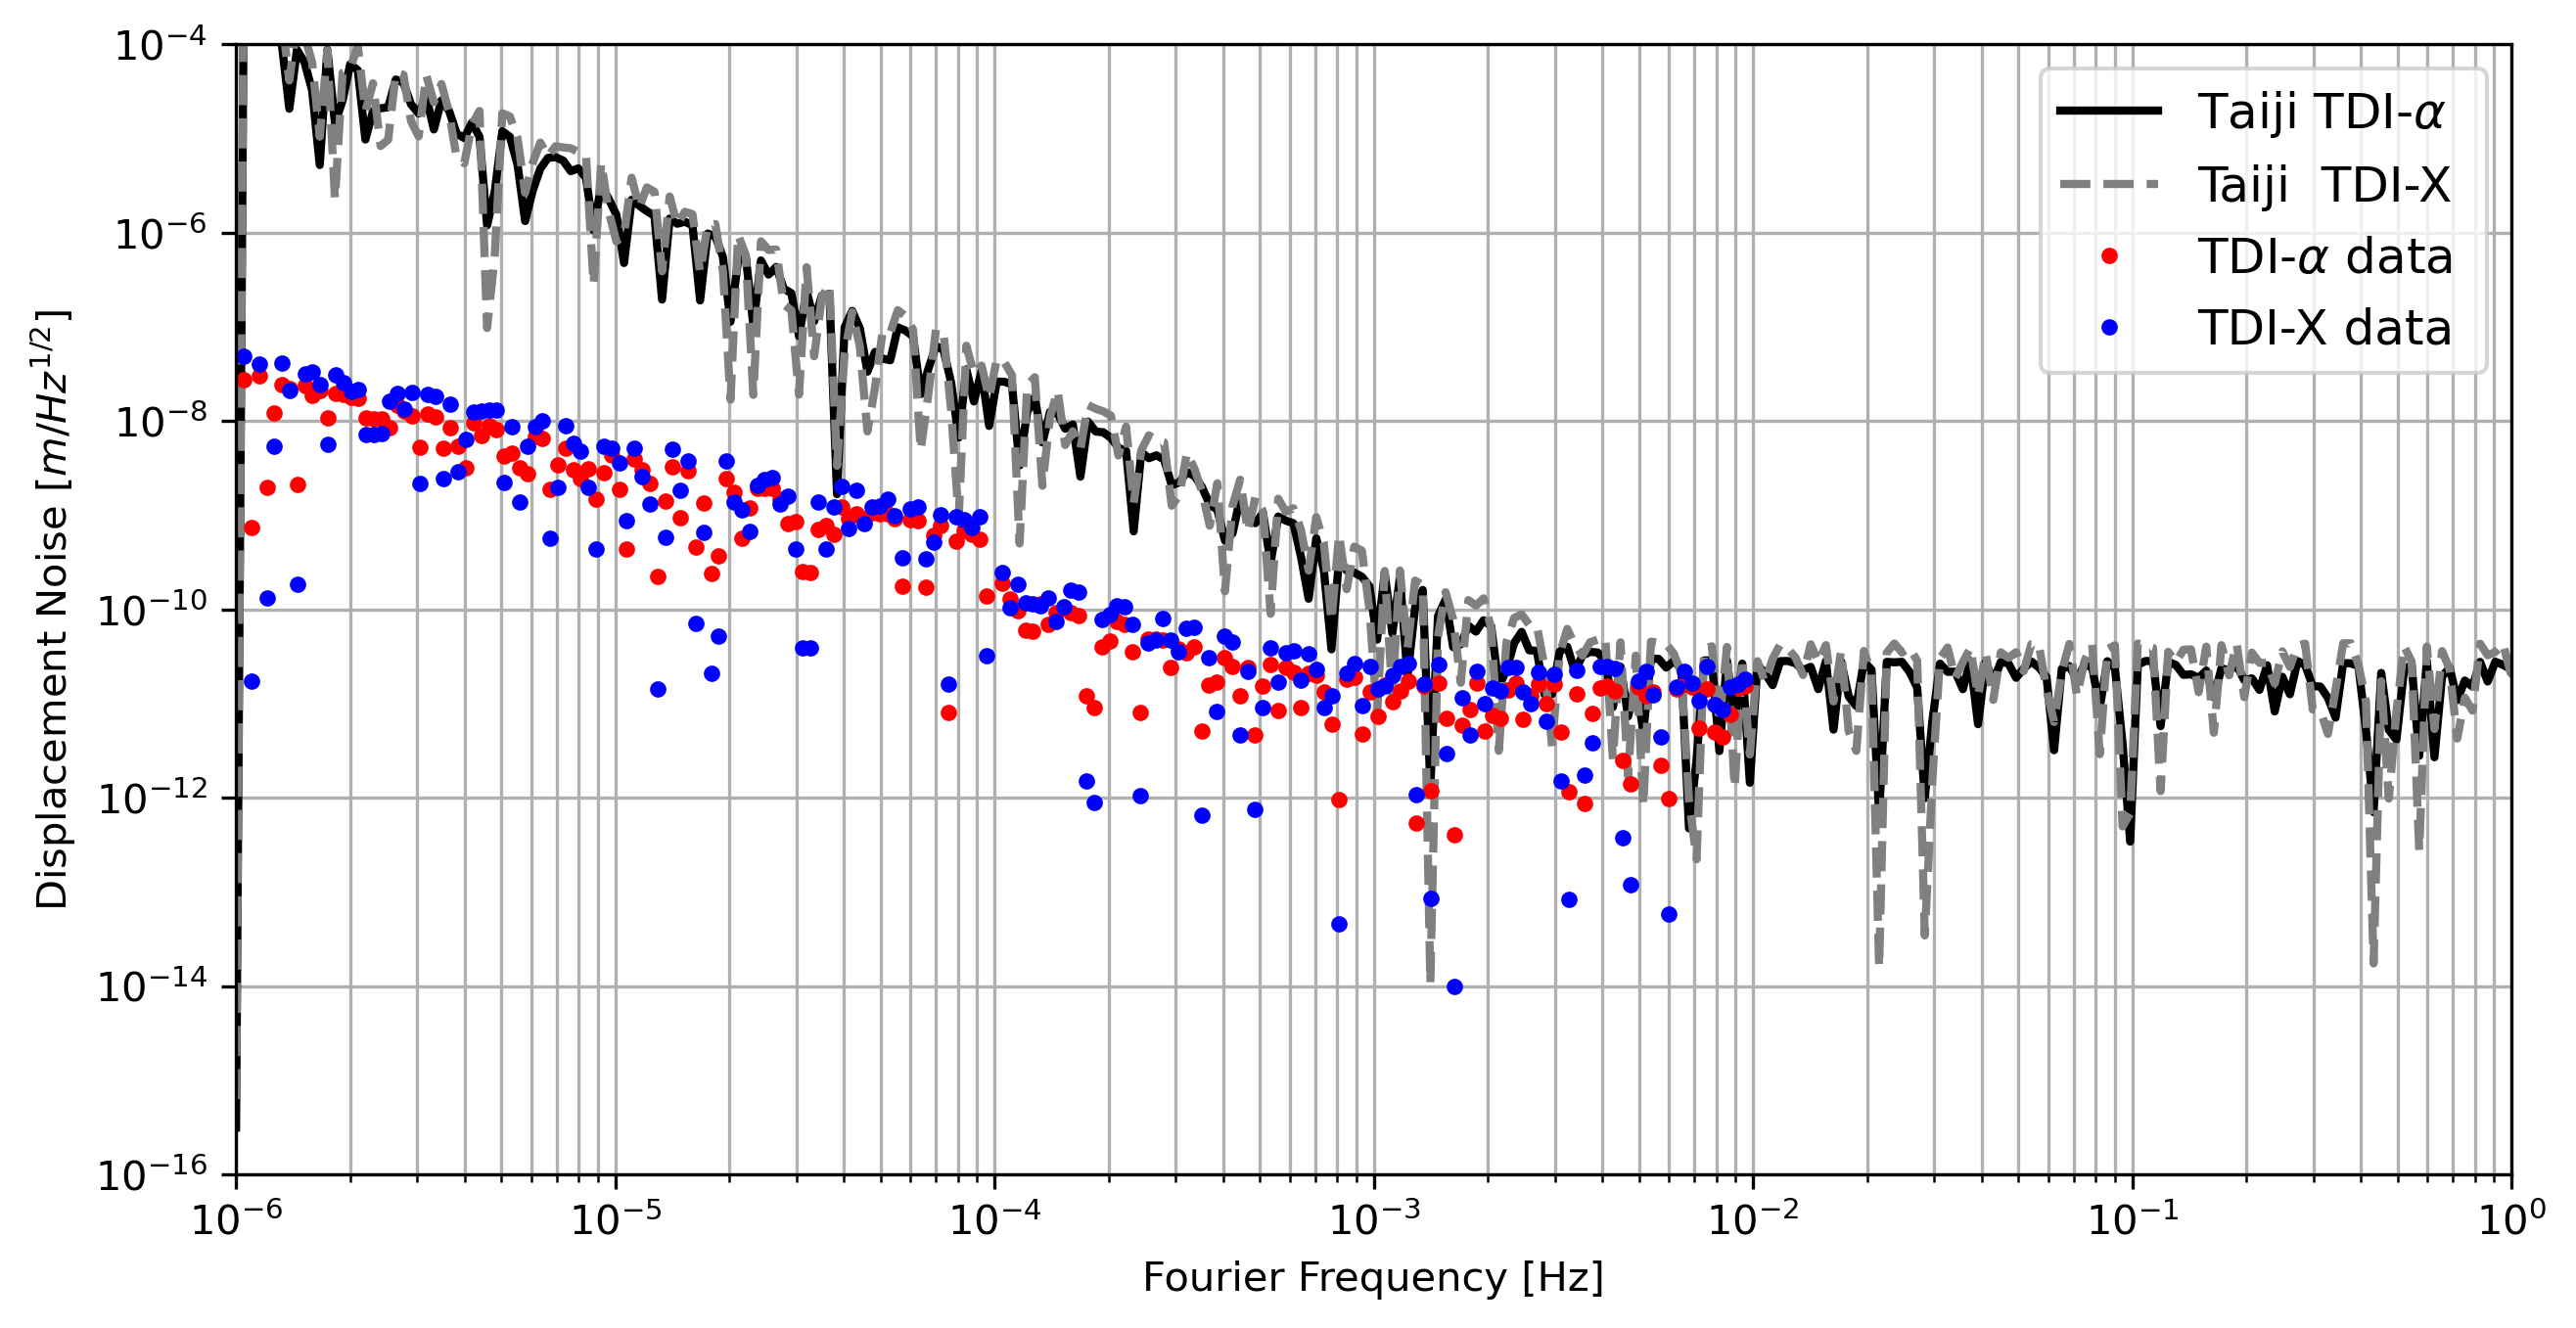

In [23]:
#tdi
#取值的计算
L = 3.0e9*u.m  
Beta = 1.0
Beta1 = 1.0  
Beta2 = 1.0
Beta3 = 1.0
lam = 1064e-9*u.m 
chi = ((lam.cgs**2)*(c.e.esu)**2)/(2*np.pi*c.m_e.cgs*(c.c.cgs**2))
chi.decompose().cgs




V = 400e3 * u.m / u.s 


def TF1arm(f,avg_type='1arm'):
    s1=4*np.sin(2*np.pi*f*L.value)*np.sin(2*np.pi*f*L.value)
    s2=4*np.cos(np.pi*f*L.value)*np.cos(np.pi*f*L.value)
    cm2m = 0.01
    prefix = (L*chi)**2
    if avg_type =='1arm':
        tf = prefix*((25/9)*(Beta**(5/3))*(V/(2*np.pi*L*f)))
    elif avg_type =='1armtdi1a':
        tf = prefix*((25/9)*(Beta2**(5/3))*(V/(2*np.pi*L*f)))*2*s1
    elif avg_type =='1armtdi1x':
        tf = prefix*((25/9)*(Beta2**(5/3))*(V/(2*np.pi*L*f)))*s1*s2*2
    elif avg_type == 'none':
        tf = prefix
    return (cm2m**2)*(tf.decompose().cgs.to_value())



f = np.array(w)

sneAll = np.array(pgram)

tfmod = '1arm'
fig, ax = plt.subplots(nrows=1, figsize=(10, 5), dpi=300)
ff1 = np.logspace(-6,1,350)

ax.plot(ff1, MRD_TDI_alpha(ff1), lw=2, color='black', linestyle='-',label=r'Taiji TDI-$\alpha$ ')
ax.plot(ff1, MRD_TDI_X(ff1), lw=2, color='grey', linestyle='--',label='Taiji  TDI-X ')

ff=[np.logspace(-6,-4,100),np.logspace(-4,-2,100)]


for i in range(2):
    
    t1 = powerlaws.PowerLaw1D(amplitude = amplitudes[i], x_0 =x_00[i], alpha = -alphas[i])
    #print(betabeta[i])
    
    if (i==1):
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1a')+32.49e-24*8*np.sin(2*np.pi*ff[i]*L.value)*np.sin(2*np.pi*ff[i]*L.value)),'.',color='red', label=r'TDI-$\alpha$ data',lw=1.5)
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1x')+32.49e-24*2*4*np.sin(2*np.pi*ff[i]*L.value)*np.sin(2*np.pi*ff[i]*L.value)*4*np.cos(np.pi*ff[i]*L.value)*np.cos(np.pi*ff[i]*L.value)),'.',color='blue',label=r'TDI-X data', lw=1.5)
    else:
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1a')+32.49e-24*8*np.sin(2*np.pi*ff[i]*L.value)*np.sin(2*np.pi*ff[i]*L.value)),'.',color='red',lw=1.5)
        plt.plot(ff[i], np.sqrt(t1(ff[i])*TF1arm(ff[i],avg_type='1armtdi1x')+32.49e-24*2*4*np.sin(2*np.pi*ff[i]*L.value)*np.sin(2*np.pi*ff[i]*L.value)*4*np.cos(np.pi*ff[i]*L.value)*np.cos(np.pi*ff[i]*L.value)),'.',color='blue',lw=1.5)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Fourier Frequency [Hz]')
ax.set_ylabel('Displacement Noise [$m/Hz^{1/2}$]')
ax.set_xlim([1e-6, 1])
ax.set_ylim([1e-16,1e-4])


ax.grid(which='both')
ax.legend(loc='upper right', fontsize=12)
fig.savefig('TDI_background_noise_taiji.jpg')